In [2]:
import matplotlib.pyplot as plt 
from ultra.visuals import make_matplotlib_pretty_again 
import ultra.visuals as v 
import numpy as np 
import math as m 
import vice 
import sys 
import os 

In [3]:
datapath = os.environ["DATA_DIRECTORY"] + "hydro/particle_track_radmix_initial.dat" 
data = np.genfromtxt(datapath).tolist() 
tform = [row[1] for row in data] 
Rform = [row[2] for row in data] 
tfinal = len(data) * [13.8] 
Rfinal = [row[4] for row in data] 

In [4]:
print(min(Rform)) 
print(max(Rform)) 
print(min(Rfinal)) 
print(max(Rfinal)) 

0.5
15.4999
0.0033
29.968


In [5]:
def get_bin_number(rad, bins): 
    for i in range(len(bins) - 1): 
        if bins[i] <= rad <= bins[i + 1]: 
            return i 
        else: 
            continue 
    return -1 

In [6]:
bins = np.linspace(0, 20, 21).tolist() 
print(bins) 
migmat = len(bins) * [None] 
counts = len(bins) * [None] 
for i in range(len(bins)): 
    migmat[i] = len(bins) * [0.] 
    counts[i] = len(bins) * [0] 
for i in range(len(data)): 
    n_init = get_bin_number(Rform[i], bins) 
    n_final = get_bin_number(Rfinal[i], bins) 
    if n_init == -1 or n_final == -1: continue 
    if n_init < n_final: 
        for j in range(n_init, n_final): 
            # normalized to 10 Myr = 0.01 Gyr 
            migmat[j + 1][j] += (n_final - n_init) / (tfinal[i] - tform[i]) * 0.01 
            counts[j + 1][j] += 1
    elif n_init > n_final: 
        for j in range(n_final, n_init): 
            migmat[j][j + 1] += (n_init - n_final) / (tfinal[i] - tform[i]) * 0.01 
            counts[j][j + 1] += 1
    else: 
        continue 
#     for j in range(n_init, n_final): 
#         if n_init < n_final: 
#             # normalized to 10 Myr = 0.01 Gyr 
#             migmat[j + 1][j] += (n_final - n_init) / (tfinal[i] - tform[i]) * 0.01 
#             counts[j + 1][j] += 1
#         elif n_init > n_final: 
#             migmat[j][j + 1] += (n_init - n_final) / (tfinal[i] - tform[i]) * 0.01 
#             counts[j][j + 1] += 1 
#         else: 
#             continue 
print(migmat)
print(counts) 
for i in range(len(bins)): 
    for j in range(len(bins)): 
        if counts[i][j] != 0: 
            migmat[i][j] /= counts[i][j] 
print(migmat) 

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
[[0.0, 64.18235460657723, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [18.68169820171663, 0.0, 123.91006040465395, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 28.896550829427486, 0.0, 171.2612080542757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 59.78468013734921, 0.0, 233.47533109989487, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 97.87223113622456, 0.0, 258.23299036811693, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 135.2534015393258, 0.0, 275.56661473894184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 163.63225801931387, 0.0, 289.15133898128687, 0.0, 0.0, 

In [37]:
from vice.yields.presets import my_yields
mz = vice.multizone(name = "diskmodel", n_zones = len(bins), n_tracers = 5) 
e_folding_times = [3 + 0.5 * (i + 1) for i in range(mz.n_zones)] 
# etas = [1 + 0.2 * (i + 1) for i in range(mz.n_zones)] 
def get_ifr(tau): 
    def ifr(t): 
        return 6.0 / (tau * (1 - m.exp(-13.8 / tau))) * m.exp(-t / tau) 
    return ifr 
for i in range(mz.n_zones): 
    mz.zones[i].Mg0 = 0. 
    mz.zones[i].bins = np.linspace(-3, 1, 401) 
    mz.zones[i].func = get_ifr(e_folding_times[i]) 
#     mz.zones[i].eta = 1 + 0.2 * (i + 1) 
    mz.zones[i].elements = ["mg", "fe", "o"] 
    for j in range(mz.n_zones): 
        mz.migration.stars[i][j] = migmat[i][j] 
        mz.migration.gas[i][j] = 0.5 * migmat[i][j] 
mz.run(np.linspace(0, 13.8, 1381)) 

Output directory already exists. Overwriting will delete all of its contents, leaving only the results of the current simulation.
Output directory: diskmodel.vice
Overwrite? (y | n) y


In [38]:
def setup_axes(): 
    fig = plt.figure(figsize = (21, 7)) 
    ax1 = fig.add_subplot(131, facecolor = "white") 
    ax2 = fig.add_subplot(132, facecolor = "white") 
    ax3 = fig.add_subplot(133, facecolor = "white") 
    ax1.set_xlabel("Time [Gyr]") 
    ax1.set_ylabel(r"$\dot{M}$") 
    ax2.set_xlabel("[Fe/H]") 
    ax2.set_ylabel("[O/Fe]") 
    ax3.set_xlabel("[O/Fe]") 
    ax3.set_ylabel("Probability Density") 
    ax3.set_yscale("log") 
    return [ax1, ax2, ax3] 

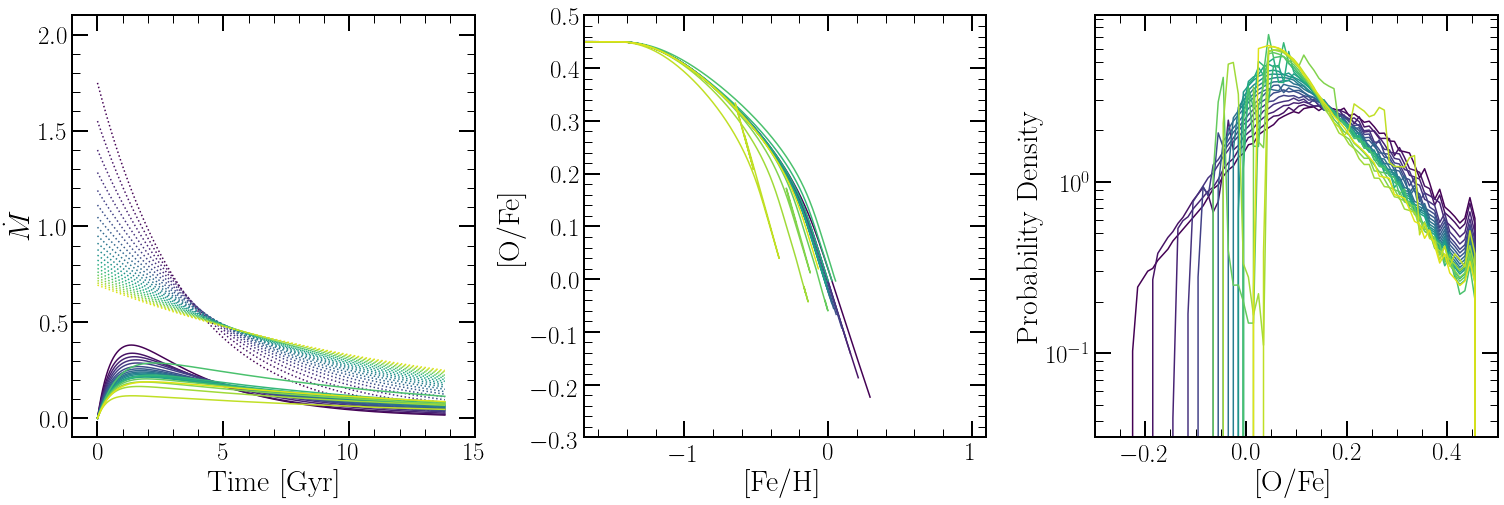

In [39]:
out = vice.output("diskmodel") 
ax1, ax2, ax3 = setup_axes() 
cmap = plt.get_cmap("viridis") 
for i in range(len(out.keys())): 
    name = "zone%d" % (i) 
    color = cmap(float(i / len(out.keys()))) 
    ax1.plot(out[name].history["time"], out[name].history["sfr"], c = color) 
    ax1.plot(out[name].history["time"], out[name].history["ifr"], c = color, linestyle = ':')  
    ax2.plot(out[name].history["[Fe/H]"], out[name].history["[O/Fe]"], c = color) 
    bin_centers = list(map(lambda x, y: (x + y) / 2., 
        out[name].mdf["bin_edge_left"], 
        out[name].mdf["bin_edge_right"])) 
    ax3.plot(bin_centers, out[name].mdf["dN/d[O/Fe]"], c = color) 
ax1.set_xlim([-1, 15]) 
ax1.set_ylim([-0.1, 2.1]) 
ax2.set_xlim([-1.7, 1.1]) 
ax2.set_ylim([-0.3, 0.5]) 
ax3.set_xlim([-0.3, 0.5]) 
plt.tight_layout() 
plt.savefig("diskmodel_o.pdf") 
plt.show() 

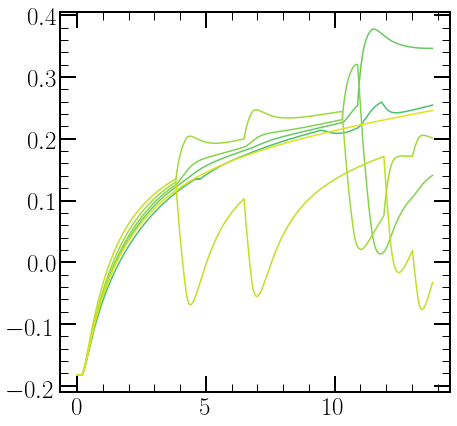

In [29]:
fig = plt.figure(figsize = (7, 7)) 
ax = fig.add_subplot(111, facecolor = "white") 
for i in range(15, len(out.keys())): 
    name = "zone%d" % (i) 
    ax.plot(out[name].history["time"], out[name].history["[Fe/Mg]"], c = cmap(float(i / len(out.keys())))) 
plt.show()